## 1. 데이터 불러오기

In [15]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [16]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

"""
[train.csv]                                         [test.csv]
ID : 샘플별 고유 ID                                 ID : 샘플별 고유 ID
gender : 성별                                       gender : 성별
age : 연령                                          age : 연령
height : 키(cm)                                     height : 키(cm)
weight : 몸무게(kg)                                 weight : 몸무게(kg)
cholesterol : 콜레스테롤 수치                       cholesterol : 콜레스테롤 수치
systolic_blood_pressure : 수축기 혈압               systolic_blood_pressure : 수축기 혈압
diastolic_blood_pressure : 이완기 혈압              diastolic_blood_pressure : 이완기 혈압
glucose : 혈당 수치(mg/dL)                          glucose : 혈당 수치(mg/dL)
bone_density : 골밀도(g/cm²)                        bone_density : 골밀도(g/cm²)
activity : 생활시 운동 강도                         activity : 생활시 운동 강도
smoke_status : 흡연 상태                            smoke_status : 흡연 상태
medical_history : 만성질환                          medical_history : 만성질환
family_medical_history : 가족력                     family_medical_history : 가족력
sleep_pattern : 수면패턴                            sleep_pattern : 수면패턴
edu_level : 학력                                    edu_level : 학력
mean_working : 1주일당 평균 근로 시간               mean_working : 1주일당 평균 근로 시간
stress_score : (TARGET) 스트레스 점수                    
"""

display(train.shape)

(3000, 18)

## 2. 데이터 전처리

In [17]:
# 카테고리형 변수의 결측값을 최빈값으로 대체
# 최빈값 -> 가장 많이 관측된 값
categorical_na_cols = train.select_dtypes(include=['object', 'category']).columns.drop('ID')

for col in categorical_na_cols:
    # # 학습 데이터에서 최빈값 계산
    # most_frequent = train[col].mode()[0]
    # print(f"{col}: {most_frequent}")
    # # 학습 데이터와 테스트 데이터 모두 해당 칼럼의 최빈값으로 대체
    # train[col] = train[col].fillna(most_frequent)
    # test[col] = test[col].fillna(most_frequent)

    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

    print(f"{col}: {train[col].unique()}")

gender: ['F' 'M']
activity: ['moderate' 'light' 'intense']
smoke_status: ['ex-smoker' 'non-smoker' 'current-smoker']
medical_history: ['high blood pressure' 'None' 'diabetes' 'heart disease']
family_medical_history: ['diabetes' 'None' 'high blood pressure' 'heart disease']
sleep_pattern: ['sleep difficulty' 'normal' 'oversleeping']
edu_level: ['bachelors degree' 'graduate degree' 'high school diploma' 'None']


In [18]:
# mean_working에 대해 중앙값 대체
# median_value = train['mean_working'].median()

# mean_working 결측치 -> 0
train['mean_working'] = train['mean_working'].fillna(0)
test['mean_working'] = test['mean_working'].fillna(0)
train.insert(17,'is_working',train['mean_working'] > 0)
test.insert(17,'is_working',test['mean_working'] > 0)
display(train.columns)

Index(['ID', 'gender', 'age', 'height', 'weight', 'cholesterol',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'bone_density', 'activity', 'smoke_status', 'medical_history',
       'family_medical_history', 'sleep_pattern', 'edu_level', 'mean_working',
       'is_working', 'stress_score'],
      dtype='object')

In [19]:
# One-Hot Encoding 적용 열 - gender, smoke_status, medical_history, family_medical_history
# 원핫 인코딩 => 카테고리끼리 순서 없을때 사용
# smoke_status는 좀 애매하긴 한듯
def one_hot_encoding(df):
    one_hot_encoding_cols = ['gender', 'smoke_status', 'medical_history', 'family_medical_history']
    encoding_df = pd.get_dummies(df, columns=one_hot_encoding_cols)
    return encoding_df

train = one_hot_encoding(train)
test = one_hot_encoding(test)

display(train.columns)
display(train.shape)

Index(['ID', 'age', 'height', 'weight', 'cholesterol',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'bone_density', 'activity', 'sleep_pattern', 'edu_level',
       'mean_working', 'is_working', 'stress_score', 'gender_F', 'gender_M',
       'smoke_status_current-smoker', 'smoke_status_ex-smoker',
       'smoke_status_non-smoker', 'medical_history_None',
       'medical_history_diabetes', 'medical_history_heart disease',
       'medical_history_high blood pressure', 'family_medical_history_None',
       'family_medical_history_diabetes',
       'family_medical_history_heart disease',
       'family_medical_history_high blood pressure'],
      dtype='object')

(3000, 28)

In [20]:
# Label Encoding 적용 열 - activity, sleep_pattern, edu_level
# 라벨 인코딩 => 카테고리끼리 순서 있을때 사용
def label_encoding(df):
    label_encoding_cols = ['activity', 'sleep_pattern', 'edu_level']
    for feature in label_encoding_cols:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

train = label_encoding(train)
test = label_encoding(test)

In [21]:
train

,ID,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,...,smoke_status_ex-smoker,smoke_status_non-smoker,medical_history_None,medical_history_diabetes,medical_history_heart disease,medical_history_high blood pressure,family_medical_history_None,family_medical_history_diabetes,family_medical_history_heart disease,family_medical_history_high blood pressure
0,TRAIN_0000,72,161.49,58.47,279.84,165,100,143.35,0.87,2,...,True,False,False,False,False,True,False,True,False,False
1,TRAIN_0001,88,179.87,77.60,257.37,178,111,146.94,0.07,2,...,True,False,True,False,False,False,False,True,False,False
2,TRAIN_0002,47,182.47,89.93,226.66,134,95,142.61,1.18,1,...,True,False,True,False,False,False,True,False,False,False
3,TRAIN_0003,69,185.78,68.63,206.74,158,92,137.26,0.48,0,...,True,False,False,False,False,True,True,False,False,False
4,TRAIN_0004,81,164.63,71.53,255.92,171,116,129.37,0.34,2,...,True,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,TRAIN_2995,87,174.43,77.14,233.31,176,111,134.71,0.20,1,...,False,True,True,False,False,False,True,False,False,False
2996,TRAIN_2996,25,171.44,51.67,196.89,143,86,111.91,1.75,2,...,False,False,True,False,False,False,True,False,False,False
2997,TRAIN_2997,54,162.13,55.54,210.52,164,91,136.47,0.80,1,...,False,False,True,False,False,False,True,False,False,False
2998,TRAIN_2998,70,181.32,82.20,234.10,182,91,144.89,0.58,2,...,False,True,True,False,False,False,True,False,False,False


## 3. 피처 엔지니어링

In [22]:
# BMI => 몸무게[kg] / 키[cm]^2
# 혈압차(맥압) => 수축성 혈압 - 이완성 혈압
def add_features(df):
    df['BMI'] = df['weight'] / ((df['height']/100)**2)
    df['bp_diff'] = df['systolic_blood_pressure'] - df['diastolic_blood_pressure']
    return df

train = add_features(train)
test = add_features(test)

In [23]:
display(train['mean_working'].describe())

# working_group 피처 만들기
bins = [3, 8, 9, 16]  # 적절한 경계값 설정
labels = [0, 1, 2]     # 저, 중하, 중상, 고 근무

train['working_group'] = pd.cut(train['mean_working'], bins=bins, labels=labels, include_lowest=True)
test['working_group'] = pd.cut(test['mean_working'], bins=bins, labels=labels, include_lowest=True)

# category -> int변환
train['working_group'] = train['working_group'].cat.codes
test['working_group'] = test['working_group'].cat.codes

q95 = train['mean_working'].quantile(0.95) # 상위 5% 기준값
q9 = train['mean_working'].quantile(0.9)
q35 = train['mean_working'].quantile(0.35)
train['is_overwork'] = (train['mean_working'] >= q95).astype(int)
test['is_overwork'] = (test['mean_working'] >= q95).astype(int)
train['is_properwork'] = ((train['mean_working'] >= q35) &(train['mean_working'] <= q9)).astype(int)
test['is_properwork'] = ((test['mean_working'] >= q35) &(test['mean_working'] <= q9)).astype(int)
train['is_noworking'] = (train['mean_working'] <= 1).astype(int)
test['is_noworking'] = (test['mean_working'] <= 1).astype(int)
display(train['working_group'].value_counts())
display(train['is_overwork'].value_counts())

count    3000.000000
mean        5.718333
std         4.346642
min         0.000000
25%         0.000000
50%         8.000000
75%         9.000000
max        16.000000
Name: mean_working, dtype: float64

working_group
-1    1032
 0     888
 2     543
 1     537
Name: count, dtype: int64

is_overwork
0    2803
1     197
Name: count, dtype: int64

In [24]:
# mean_working & sleep_pattern 피처 엔지니어링

train['work_sleep_imbalance'] = train['mean_working'] / (train['sleep_pattern'] + 1)
test['work_sleep_imbalance'] = test['mean_working'] / (test['sleep_pattern'] + 1)

display(train[['work_sleep_imbalance', 'stress_score']])

for col in train.columns:
    if col not in ['ID', 'stress_score']:
        corr_val = train['stress_score'].corr(train[col])
        print(f"{col} ↔ stress_score 상관계수: {corr_val:.4f}")

,work_sleep_imbalance,stress_score
0,0.0,0.63
1,0.0,0.83
2,9.0,0.70
3,0.0,0.17
4,0.0,0.36
...,...,...
2995,0.0,0.02
2996,9.0,0.16
2997,9.0,0.16
2998,0.0,0.18


age ↔ stress_score 상관계수: 0.0187
height ↔ stress_score 상관계수: -0.0057
weight ↔ stress_score 상관계수: 0.0113
cholesterol ↔ stress_score 상관계수: 0.0213
systolic_blood_pressure ↔ stress_score 상관계수: 0.0156
diastolic_blood_pressure ↔ stress_score 상관계수: 0.0254
glucose ↔ stress_score 상관계수: -0.0061
bone_density ↔ stress_score 상관계수: -0.0226
activity ↔ stress_score 상관계수: 0.0070
sleep_pattern ↔ stress_score 상관계수: 0.0002
edu_level ↔ stress_score 상관계수: -0.0271
mean_working ↔ stress_score 상관계수: 0.0240
is_working ↔ stress_score 상관계수: -0.0228
gender_F ↔ stress_score 상관계수: 0.0136
gender_M ↔ stress_score 상관계수: -0.0136
smoke_status_current-smoker ↔ stress_score 상관계수: 0.0261
smoke_status_ex-smoker ↔ stress_score 상관계수: -0.0320
smoke_status_non-smoker ↔ stress_score 상관계수: 0.0087
medical_history_None ↔ stress_score 상관계수: -0.0504
medical_history_diabetes ↔ stress_score 상관계수: 0.0245
medical_history_heart disease ↔ stress_score 상관계수: 0.0000
medical_history_high blood pressure ↔ stress_score 상관계수: 0.0373
family_medical

## 4. 모델링

In [25]:
train = train.drop(['ID'], axis = 1)
target = train.pop('stress_score')
test1 = test.pop('ID')
 

# 타겟을 구간화 
# target2 = pd.qcut(target, q=10, duplicates='drop')  # 중복 구간 방지

x_train,x_test,y_train,y_test = train_test_split(train,target,test_size=0.2,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2400, 33), (600, 33), (2400,), (600,))

## 5. 하이퍼 파라미터

In [26]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         'random_state': 0
#     }

#     model = XGBRegressor(**params)

#     # 5-Fold Cross Validation, scoring은 음수 MAE
#     score = cross_val_score(
#         model, x_train, y_train,
#         scoring='neg_mean_absolute_error',  # MAE가 작을수록 좋으므로 음수로 나옴
#         cv=5
#     )
    
#     return -score.mean()  # 음수 MAE → 양수 MAE로 바꿔 반환

# # Optuna 실행
# study = optuna.create_study(direction='minimize')  # MAE 최소화
# study.optimize(objective, n_trials=30)  # 30번 탐색

# # 최적 파라미터 출력
# print("Best trial:")
# print("  Value: {:.4f}".format(study.best_value))
# print("  Params: ")
# for key, value in study.best_params.items():
#     print("    {}: {}".format(key, value))
#     # Value: 0.1901
#   Params: 
#     n_estimators: 495
#     max_depth: 8
#     learning_rate: 0.08978531996274
#     subsample: 0.6899092290875395
#     colsample_bytree: 0.7892881886147097
#     reg_alpha: 0.023309401535107244
#     reg_lambda: 6.837763487395467


C:\Users\seong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# best_params = {
#     'n_estimators': 495,
#     'max_depth': 8,
#     'learning_rate': 0.08978531996274,
#     'subsample': 0.6899092290875395,
#     'colsample_bytree': 0.7892881886147097,
#     'reg_alpha': 0.023309401535107244,
#     'reg_lambda': 6.837763487395467
# }

# # best_model = xgb.XGBRegressor(**study.best_params, random_state=0)
# best_model = XGBRegressor(**best_params)
# best_model.fit(x_train, y_train)

# # 예측 및 MAE 측정
# y_pred = best_model.predict(x_test)
# mae = mean_absolute_error(y_test, y_pred)
# print(f"Test MAE: {mae:.4f}")
# #Test MAE: 0.1875-2차
# #Test MAE: 0.1732 -3차
# #Test MAE: 0.1847 -4차


Test MAE: 0.1875


In [ ]:
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import train_test_split
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor


# # 최적 파라미터
# best_params = {
#     'lgbm_n_estimators': 164,
#     'lgbm_learning_rate': 0.19895196162082854,
#     'lgbm_num_leaves': 45,
#     'xgb_n_estimators': 696,
#     'xgb_learning_rate': 0.14333552365175503,
#     'xgb_max_depth': 10,
#     'cat_iterations': 884,
#     'cat_learning_rate': 0.14468764366716041,
#     'cat_depth': 8,
#     'w_lgbm': 0.7505228671773148,
#     'w_xgb': 0.5192950338646558,
#     'w_cat': 0.8627459136063318
# }

# # 모델 정의
# lgbm = LGBMRegressor(
#     n_estimators=best_params['lgbm_n_estimators'],
#     learning_rate=best_params['lgbm_learning_rate'],
#     num_leaves=best_params['lgbm_num_leaves'],
#     random_state=42
# )

# xgb = XGBRegressor(
#     n_estimators=best_params['xgb_n_estimators'],
#     learning_rate=best_params['xgb_learning_rate'],
#     max_depth=best_params['xgb_max_depth'],
#     random_state=42
# )

# cat = CatBoostRegressor(
#     iterations=best_params['cat_iterations'],
#     learning_rate=best_params['cat_learning_rate'],
#     depth=best_params['cat_depth'],
#     random_seed=42,
#     verbose=0
# )

# # 학습
# lgbm.fit(x_train, y_train)
# xgb.fit(x_train, y_train)
# cat.fit(x_train, y_train)

# # 예측
# pred_lgbm = lgbm.predict(x_test)
# pred_xgb = xgb.predict(x_test)
# pred_cat = cat.predict(x_test)

# # 가중치 정규화
# w_lgbm = best_params['w_lgbm']
# w_xgb = best_params['w_xgb']
# w_cat = best_params['w_cat']
# total_weight = w_lgbm + w_xgb + w_cat
# w_lgbm /= total_weight
# w_xgb /= total_weight
# w_cat /= total_weight

# # 앙상블 예측
# pred_ensemble = w_lgbm * pred_lgbm + w_xgb * pred_xgb + w_cat * pred_cat

# # MAE 출력
# mae = mean_absolute_error(y_test, pred_ensemble)
# print(f"앙상블 모델 MAE: {mae:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 33
[LightGBM] [Info] Start training from score 0.481992
앙상블 모델 MAE: 0.1842


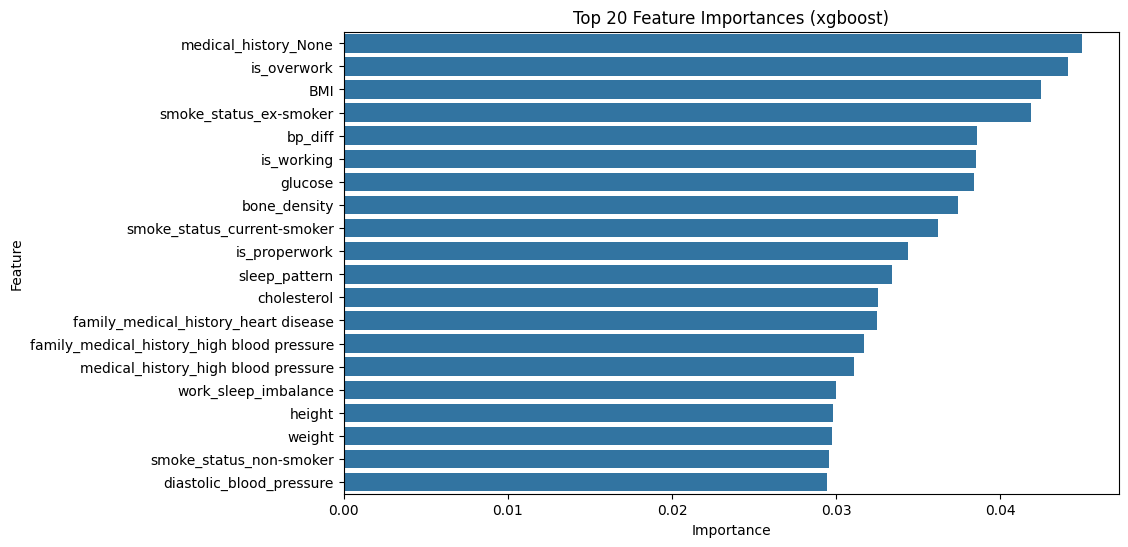

In [29]:
importances = best_model.feature_importances_
feature_names = x_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (xgboost)')
plt.show()

In [ ]:
#MAE는 GAIN기준 시각화
# import matplotlib.pyplot as plt
# import xgboost as xgb

# fig, ax = plt.subplots(figsize=(8, 6))  # 가로, 세로 조절
# xgb.plot_importance(
#     best_model,
#     importance_type='gain',
#     max_num_features=10,
#     height=0.5,  # 막대 간격 조절
#     ax=ax        # 커스텀 axis 사용
# )
# plt.title("Top 10 Important Features (by Gain)")
# plt.tight_layout()
# plt.show()


In [ ]:
pred = best_model.predict(test)
result = pd.DataFrame({'ID':test1,'stress_score':pred})
result.to_csv("result1.csv",index=False)
result.head()

In [ ]:
#교차검증
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import cross_val_score
# mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
# a = cross_val_score(best_model, x_train, y_train, cv=5, scoring=mae_scorer)
# print("각 5번 MAE 점수:", -a) 
#1차: 각 5번 MAE 점수: [0.19468601 0.18344834 0.18882323 0.19405231 0.18956949]

#다른 평가 지표와 비교
# from sklearn.model_selection import cross_val_score

# # MAE (음수로 바꾸기)-mae와 rmse차이가 크면 예측 실패 + R2로 선형성 확인 
# mae_scores = -cross_val_score(best_model, x_train, y_train, scoring='neg_mean_absolute_error', cv=5)
# rmse_scores = np.sqrt(-cross_val_score(best_model, x_train, y_train, scoring='neg_mean_squared_error', cv=5))
# r2_scores = cross_val_score(best_model, x_train, y_train, scoring='r2', cv=5)

# print(f"MAE     (cv5 mean): {mae_scores.mean():.4f}")
# print(f"RMSE    (cv5 mean): {rmse_scores.mean():.4f}")
# print(f"R^2     (cv5 mean): {r2_scores.mean():.4f}")
# #MAE     (cv5 mean): 0.1890
# RMSE    (cv5 mean): 0.2512
# R^2     (cv5 mean): 0.2318

In [ ]:
# train에서 나눠서 데이콘에서 측정하는 MAE와 다를수있음
# 성능이 올라갔는지 그대로인지 내려갔는지 경향만 파악할 수 있음
# 확인용으로만 쓸것

# import datetime

# # MAE 로그파일 세팅
# def loging(MAE):
#     with open('./mae_log', mode='a', encoding='utf-8') as f:
#         current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#         f.write(f"시간: {current_time} / MAE: {MAE}\n")

# # MAE 체크용
# train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)

# X_train = train_set.drop(['ID', 'stress_score'], axis=1)
# y_train = train_set['stress_score']

# X_val = val_set.drop(['ID', 'stress_score'], axis=1) 
# y_val = val_set['stress_score']

# lgbm = LGBMRegressor(random_state=42)
# lgbm.fit(X_train, y_train)

# val_pred = lgbm.predict(X_val)

# MAE = mean_absolute_error(y_val, val_pred)

# print(f"모델의 검증 MAE 점수: {MAE}")
# loging(MAE)